# Housng Time Series Model

The time series model aims to represent the overall trend of Houston, TX housing. The top 15 size ranked zipcodes from 2011-2016 to train the model and 2017 to test. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [5]:
# filtering the data set to Texas and Houston
df_set = df[(df.State == 'TX') & (df.City == 'Houston')]
df_set

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
44,91685,77036,Houston,TX,Houston,Harris,45,120400.0,118700.0,117300.0,...,174900,174600,175000,176000,177200,177700,177700,179800,185100,189800
63,91726,77077,Houston,TX,Houston,Harris,64,177100.0,180000.0,182700.0,...,309600,310000,310800,311600,311800,311200,310500,311400,313800,315900
182,91744,77095,Houston,TX,Houston,Harris,183,131700.0,131300.0,131100.0,...,208900,210200,210700,211200,212300,213100,212800,214300,217500,219600
279,91731,77082,Houston,TX,Houston,Harris,280,101600.0,101300.0,100800.0,...,165800,166600,167600,168400,169000,169800,170800,171800,172500,172900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7892,91727,77078,Houston,TX,Houston,Harris,7893,45700.0,45700.0,45700.0,...,93400,94700,96700,98100,97500,96600,96600,97500,98500,99400
8125,91717,77068,Houston,TX,Houston,Harris,8126,136300.0,135900.0,135500.0,...,205700,205700,206200,206800,207100,207600,207800,208700,210300,211500
8230,91681,77032,Houston,TX,Houston,Harris,8231,57100.0,57100.0,57000.0,...,104800,105600,106500,108200,111200,113600,115600,117400,118800,119200
8357,91743,77094,Houston,TX,Houston,Harris,8358,356300.0,357700.0,358800.0,...,375100,374400,374100,374700,375300,375000,373400,372800,373600,373900


In [6]:
# sort by the size rank of each zipcode
df_set = df_set.sort_values(by='SizeRank')
df_set

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
44,91685,77036,Houston,TX,Houston,Harris,45,120400.0,118700.0,117300.0,...,174900,174600,175000,176000,177200,177700,177700,179800,185100,189800
63,91726,77077,Houston,TX,Houston,Harris,64,177100.0,180000.0,182700.0,...,309600,310000,310800,311600,311800,311200,310500,311400,313800,315900
182,91744,77095,Houston,TX,Houston,Harris,183,131700.0,131300.0,131100.0,...,208900,210200,210700,211200,212300,213100,212800,214300,217500,219600
279,91731,77082,Houston,TX,Houston,Harris,280,101600.0,101300.0,100800.0,...,165800,166600,167600,168400,169000,169800,170800,171800,172500,172900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7892,91727,77078,Houston,TX,Houston,Harris,7893,45700.0,45700.0,45700.0,...,93400,94700,96700,98100,97500,96600,96600,97500,98500,99400
8125,91717,77068,Houston,TX,Houston,Harris,8126,136300.0,135900.0,135500.0,...,205700,205700,206200,206800,207100,207600,207800,208700,210300,211500
8230,91681,77032,Houston,TX,Houston,Harris,8231,57100.0,57100.0,57000.0,...,104800,105600,106500,108200,111200,113600,115600,117400,118800,119200
8357,91743,77094,Houston,TX,Houston,Harris,8358,356300.0,357700.0,358800.0,...,375100,374400,374100,374700,375300,375000,373400,372800,373600,373900


In [7]:
# grab only the top 15 size ranks
df_set = df_set[:15]
df_set

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
44,91685,77036,Houston,TX,Houston,Harris,45,120400.0,118700.0,117300.0,...,174900,174600,175000,176000,177200,177700,177700,179800,185100,189800
63,91726,77077,Houston,TX,Houston,Harris,64,177100.0,180000.0,182700.0,...,309600,310000,310800,311600,311800,311200,310500,311400,313800,315900
182,91744,77095,Houston,TX,Houston,Harris,183,131700.0,131300.0,131100.0,...,208900,210200,210700,211200,212300,213100,212800,214300,217500,219600
279,91731,77082,Houston,TX,Houston,Harris,280,101600.0,101300.0,100800.0,...,165800,166600,167600,168400,169000,169800,170800,171800,172500,172900
321,91706,77057,Houston,TX,Houston,Harris,322,448800.0,450100.0,451500.0,...,566300,566500,567200,566600,562200,554300,547900,548400,557300,565000
387,91656,77007,Houston,TX,Houston,Harris,388,311900.0,308000.0,303500.0,...,402100,403600,405600,407100,406600,405500,405000,406300,409500,411700
529,91719,77070,Houston,TX,Houston,Harris,530,120000.0,119600.0,119200.0,...,192300,192700,193400,193900,194500,194800,195000,195600,197000,197900
817,91730,77081,Houston,TX,Houston,Harris,818,273800.0,275500.0,277200.0,...,372000,371700,370000,370200,372300,374800,379200,384600,389200,391800
819,91712,77063,Houston,TX,Houston,Harris,820,224200.0,228000.0,231800.0,...,334100,336700,337600,337400,338900,339600,337000,339400,348700,355800


In [8]:
df_set.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

Filtering dataset to the top 15 Size Rank in Houston,TX Harris County. 

In [9]:
df_set.reset_index(drop=True, inplace=True)

In [10]:
df_info = df_set.loc[:, ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank']]

In [11]:
final_df = pd.concat([df_info, df_set.loc[:,'2011-01': '2017-12']], axis=1)

In [12]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [13]:
date_time_idx = get_datetimes(final_df)

In [14]:
date_time_idx

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
      

In [15]:
date_time_idx = date_time_idx.strftime('%Y-%m')

In [16]:
date_time_idx

Index(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', 

In [17]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [18]:
zipcode_data = {}
for i in range(0,15):
    zipcode_data[str(final_df.loc[i, 'RegionName'])] = melt_data(pd.DataFrame(final_df.iloc[i:i+1, :], columns=final_df.columns))

In [19]:
z = pd.DataFrame()
for key in zipcode_data.keys():
    z = pd.concat([z , zipcode_data[key]], axis=1)

In [20]:
z.values

array([[118800., 125000., 207100., ...,  86700., 289000., 120500.],
       [118300., 125400., 207100., ...,  86400., 288700., 119700.],
       [118200., 125900., 207600., ...,  86300., 289000., 119500.],
       ...,
       [161900., 176000., 311600., ..., 127100., 425500., 166300.],
       [162800., 177200., 311800., ..., 128500., 426500., 168600.],
       [162800., 177700., 311200., ..., 129700., 427600., 171100.]])

In [21]:
zipcode = pd.DataFrame(z.values, columns=zipcode_data.keys())

In [22]:
zipcode.info()
zipcode.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   77084   84 non-null     float64
 1   77036   84 non-null     float64
 2   77077   84 non-null     float64
 3   77095   84 non-null     float64
 4   77082   84 non-null     float64
 5   77057   84 non-null     float64
 6   77007   84 non-null     float64
 7   77070   84 non-null     float64
 8   77081   84 non-null     float64
 9   77063   84 non-null     float64
 10  77042   84 non-null     float64
 11  77072   84 non-null     float64
 12  77015   84 non-null     float64
 13  77008   84 non-null     float64
 14  77040   84 non-null     float64
dtypes: float64(15)
memory usage: 10.0 KB


,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
0,118800.0,125000.0,207100.0,155600.0,118900.0,439200.0,297300.0,144400.0,259500.0,244100.0,256900.0,83700.0,86700.0,289000.0,120500.0
1,118300.0,125400.0,207100.0,154600.0,118200.0,436900.0,296600.0,143800.0,257300.0,243800.0,255400.0,83400.0,86400.0,288700.0,119700.0
2,118200.0,125900.0,207600.0,154500.0,117900.0,435100.0,296600.0,143200.0,256000.0,244100.0,255000.0,82800.0,86300.0,289000.0,119500.0
3,118100.0,126200.0,209100.0,154800.0,117500.0,435200.0,297200.0,142900.0,258400.0,244400.0,255700.0,82200.0,86300.0,290100.0,119700.0
4,118000.0,126400.0,210700.0,155100.0,117000.0,436600.0,298200.0,142800.0,261900.0,245600.0,256500.0,82100.0,86200.0,292000.0,119600.0


In [23]:
zipcode = zipcode.set_index(date_time_idx)
zipcode

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
2011-01,118800.0,125000.0,207100.0,155600.0,118900.0,439200.0,297300.0,144400.0,259500.0,244100.0,256900.0,83700.0,86700.0,289000.0,120500.0
2011-02,118300.0,125400.0,207100.0,154600.0,118200.0,436900.0,296600.0,143800.0,257300.0,243800.0,255400.0,83400.0,86400.0,288700.0,119700.0
2011-03,118200.0,125900.0,207600.0,154500.0,117900.0,435100.0,296600.0,143200.0,256000.0,244100.0,255000.0,82800.0,86300.0,289000.0,119500.0
2011-04,118100.0,126200.0,209100.0,154800.0,117500.0,435200.0,297200.0,142900.0,258400.0,244400.0,255700.0,82200.0,86300.0,290100.0,119700.0
2011-05,118000.0,126400.0,210700.0,155100.0,117000.0,436600.0,298200.0,142800.0,261900.0,245600.0,256500.0,82100.0,86200.0,292000.0,119600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,158700.0,174600.0,310000.0,210200.0,166600.0,566500.0,403600.0,192700.0,371700.0,336700.0,381600.0,122900.0,125900.0,421000.0,164600.0
2017-09,160200.0,175000.0,310800.0,210700.0,167600.0,567200.0,405600.0,193400.0,370000.0,337600.0,381300.0,122800.0,126200.0,423500.0,165200.0
2017-10,161900.0,176000.0,311600.0,211200.0,168400.0,566600.0,407100.0,193900.0,370200.0,337400.0,381800.0,123700.0,127100.0,425500.0,166300.0
2017-11,162800.0,177200.0,311800.0,212300.0,169000.0,562200.0,406600.0,194500.0,372300.0,338900.0,382000.0,124800.0,128500.0,426500.0,168600.0


In [24]:
zipcode.to_csv('dataframe.csv')

In [25]:
zipcode.head()

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
2011-01,118800.0,125000.0,207100.0,155600.0,118900.0,439200.0,297300.0,144400.0,259500.0,244100.0,256900.0,83700.0,86700.0,289000.0,120500.0
2011-02,118300.0,125400.0,207100.0,154600.0,118200.0,436900.0,296600.0,143800.0,257300.0,243800.0,255400.0,83400.0,86400.0,288700.0,119700.0
2011-03,118200.0,125900.0,207600.0,154500.0,117900.0,435100.0,296600.0,143200.0,256000.0,244100.0,255000.0,82800.0,86300.0,289000.0,119500.0
2011-04,118100.0,126200.0,209100.0,154800.0,117500.0,435200.0,297200.0,142900.0,258400.0,244400.0,255700.0,82200.0,86300.0,290100.0,119700.0
2011-05,118000.0,126400.0,210700.0,155100.0,117000.0,436600.0,298200.0,142800.0,261900.0,245600.0,256500.0,82100.0,86200.0,292000.0,119600.0


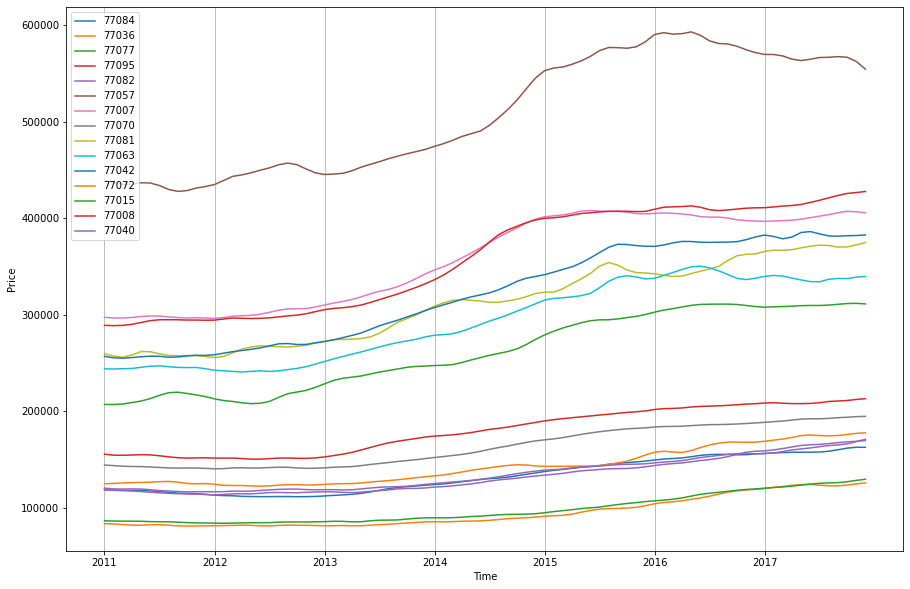

In [26]:
zipcode.plot(figsize=(15,10), 
             use_index=True,
             xlabel='Time', 
             ylabel='Price')

xlabels = [2011,2012,2013,2014,2015,2016,2017]
plt.grid(axis='x')
plt.xticks(ticks=range(0,len(zipcode.index),12), labels=xlabels);

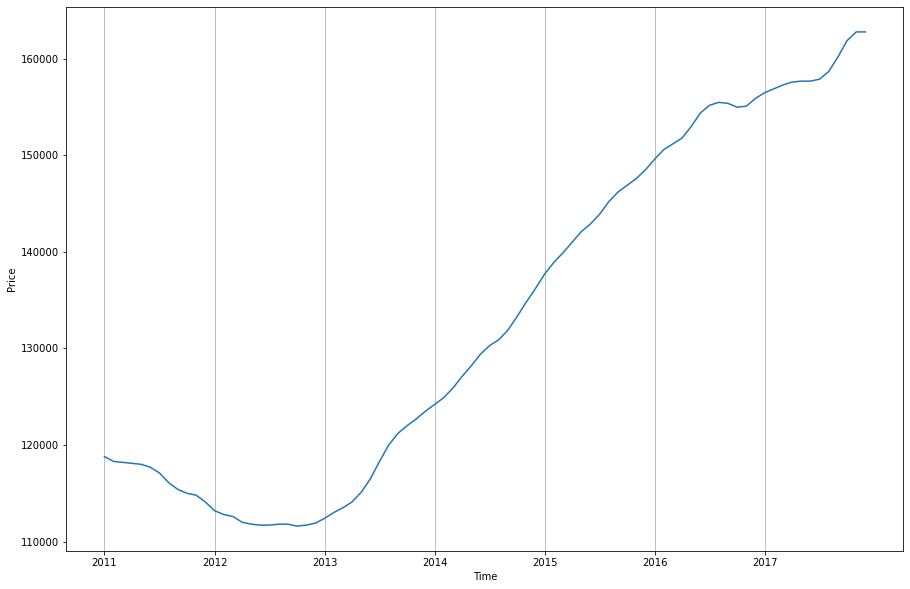

In [27]:
f, ax = plt.subplots()

ax1 = zipcode['77084'].plot(figsize=(15,10), 
             use_index=True,
             xlabel='Time', 
             ylabel='Price')



xlabels = [2011,2012,2013,2014,2015,2016,2017]
plt.grid(axis='x')
plt.xticks(ticks=range(0,len(zipcode.index),12), labels=xlabels);

In [28]:
zipcode.describe()

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,133179.761905,142879.761905,262114.285714,179892.857143,132952.380952,508159.523810,357695.238095,163551.190476,311553.571429,293391.666667,321408.333333,95198.809524,98421.428571,358488.095238,135173.809524
std,17857.155967,18473.568091,39424.676215,22922.492693,18190.189837,60473.192545,46045.467066,20263.347492,41116.104916,40893.665248,49445.986615,15541.723820,14719.883049,52363.954320,16836.800765
min,111600.000000,122500.000000,207100.000000,150500.000000,113500.000000,427700.000000,296200.000000,140500.000000,255700.000000,240700.000000,255000.000000,81200.000000,84100.000000,288700.000000,116700.000000
25%,115925.000000,125700.000000,219950.000000,154575.000000,116450.000000,448575.000000,306150.000000,142475.000000,267775.000000,246575.000000,269750.000000,82100.000000,85800.000000,299400.000000,119425.000000
50%,129850.000000,140950.000000,256800.000000,180500.000000,127000.000000,493200.000000,372050.000000,159650.000000,314600.000000,291700.000000,321600.000000,86900.000000,91850.000000,371400.000000,130300.000000
75%,151350.000000,158100.000000,306675.000000,203125.000000,146075.000000,567600.000000,402175.000000,184450.000000,346550.000000,337450.000000,374525.000000,106650.000000,109350.000000,408825.000000,148325.000000
max,162800.000000,177700.000000,311800.000000,213100.000000,169800.000000,592800.000000,407900.000000,194800.000000,374800.000000,350300.000000,386100.000000,125900.000000,129700.000000,427600.000000,171100.000000


In [29]:
zipcode.mean().sort_values(ascending=False)

77057    508159.523810
77008    358488.095238
77007    357695.238095
77042    321408.333333
77081    311553.571429
77063    293391.666667
77077    262114.285714
77095    179892.857143
77070    163551.190476
77036    142879.761905
77040    135173.809524
77084    133179.761905
77082    132952.380952
77015     98421.428571
77072     95198.809524
dtype: float64

In [30]:
zipcode.std().sort_values(ascending=False)

77057    60473.192545
77008    52363.954320
77042    49445.986615
77007    46045.467066
77081    41116.104916
77063    40893.665248
77077    39424.676215
77095    22922.492693
77070    20263.347492
77036    18473.568091
77082    18190.189837
77084    17857.155967
77040    16836.800765
77072    15541.723820
77015    14719.883049
dtype: float64

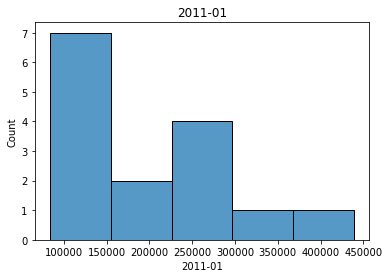

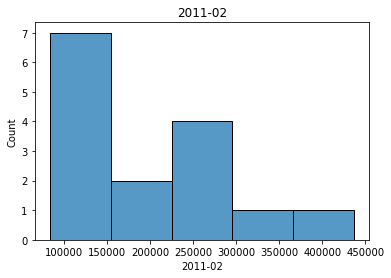

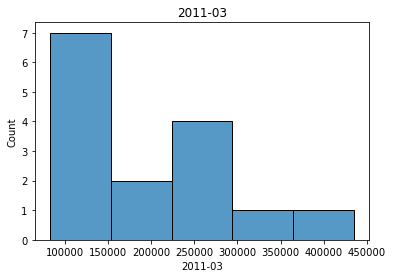

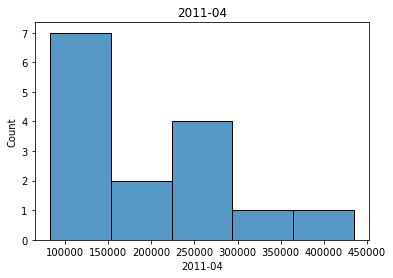

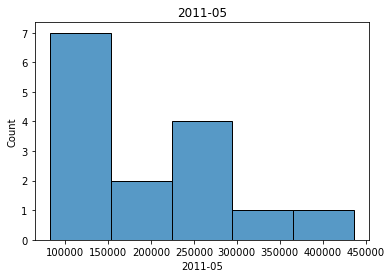

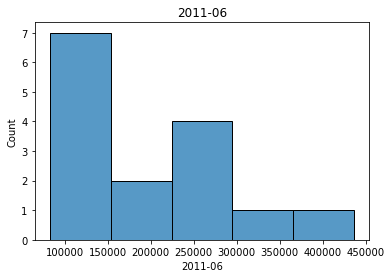

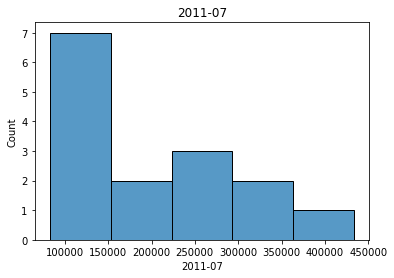

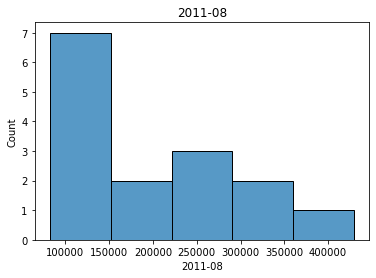

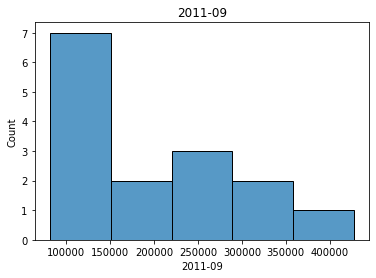

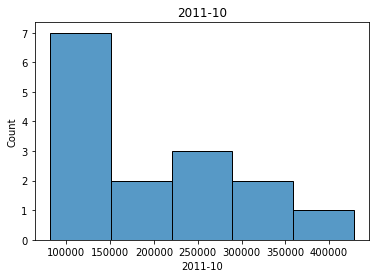

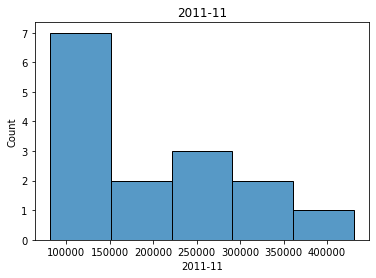

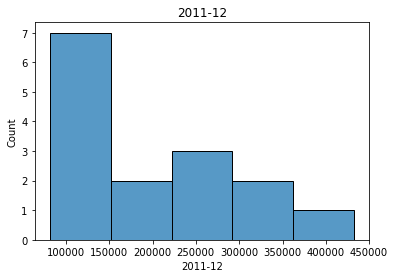

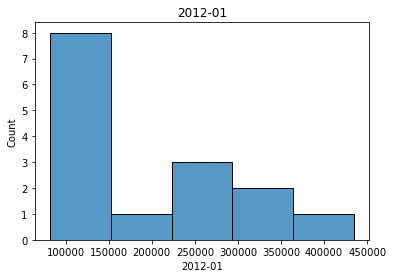

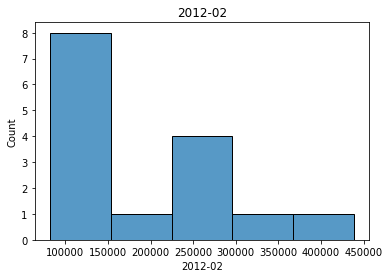

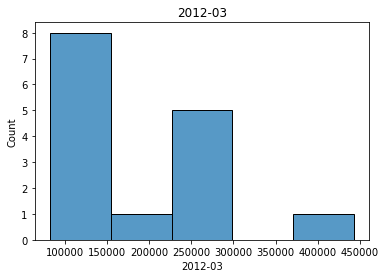

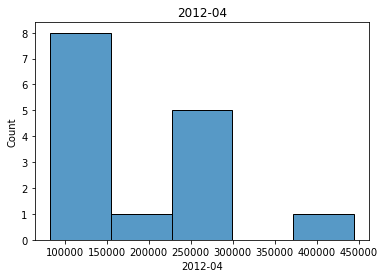

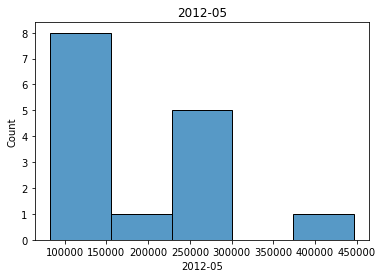

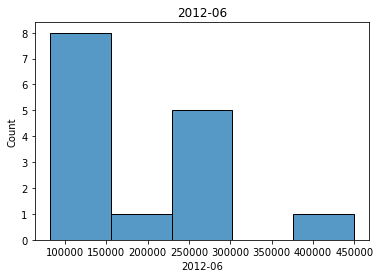

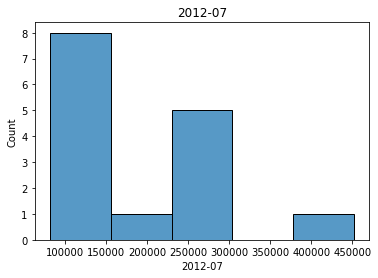

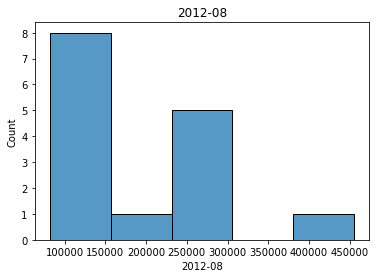

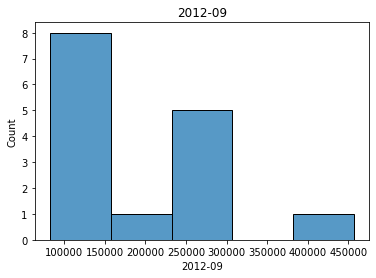

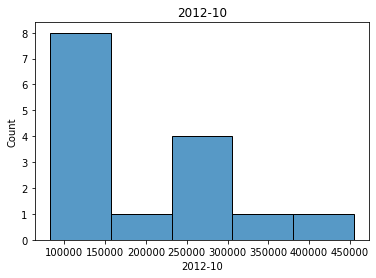

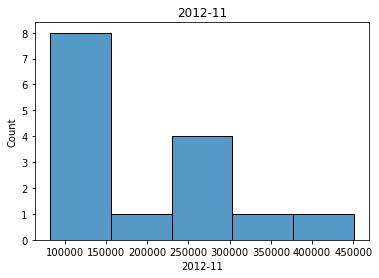

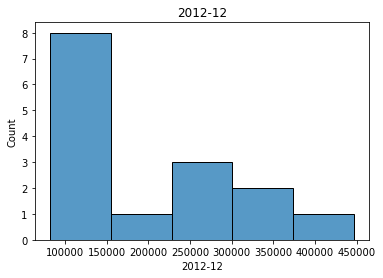

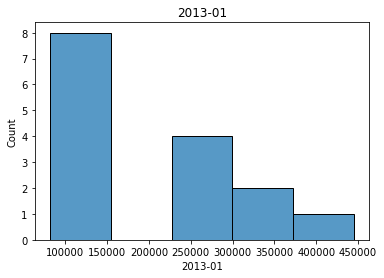

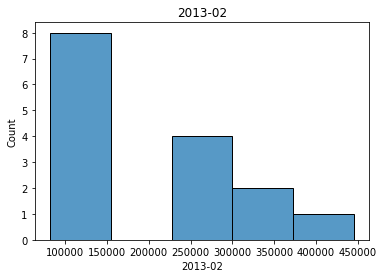

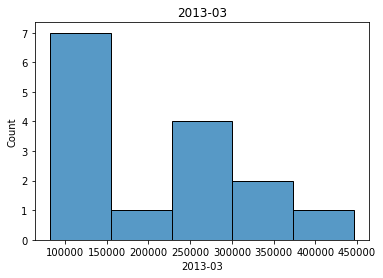

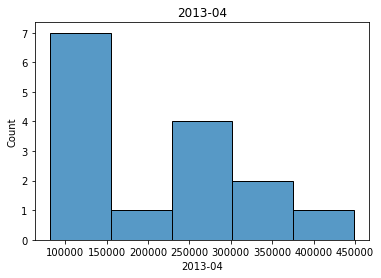

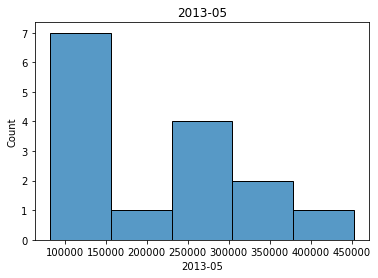

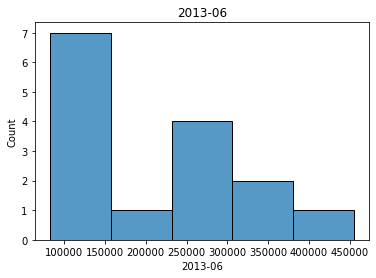

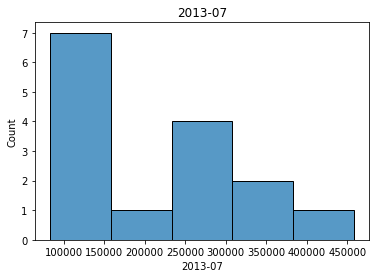

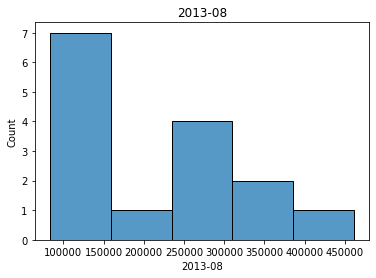

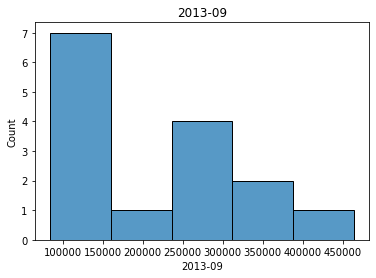

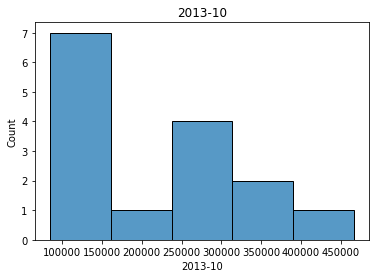

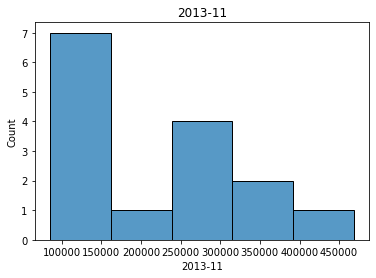

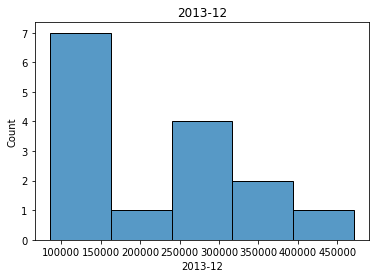

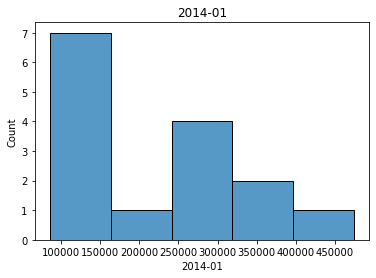

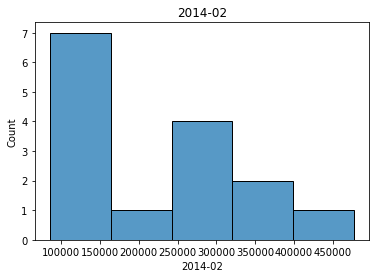

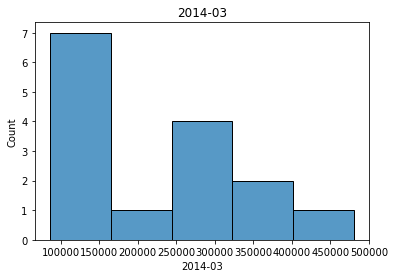

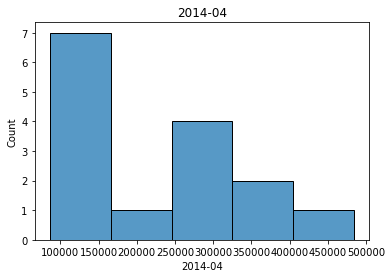

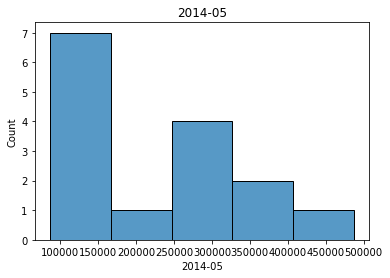

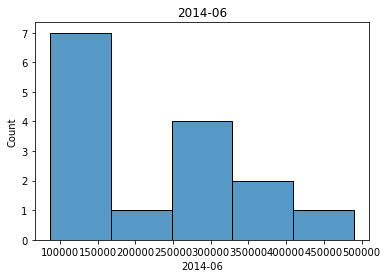

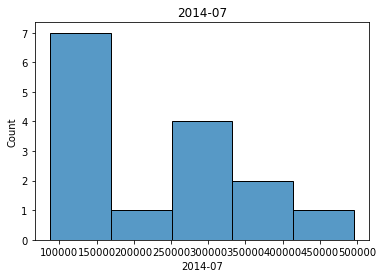

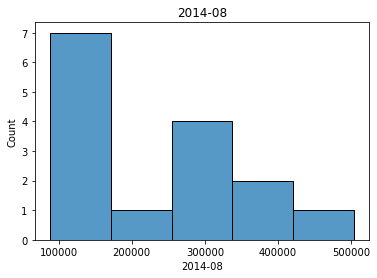

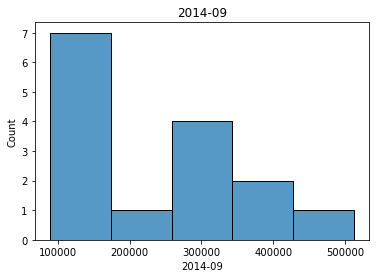

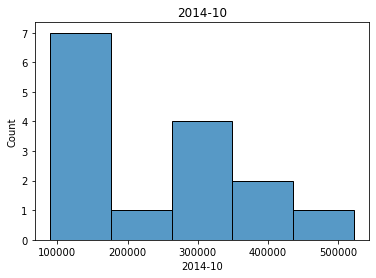

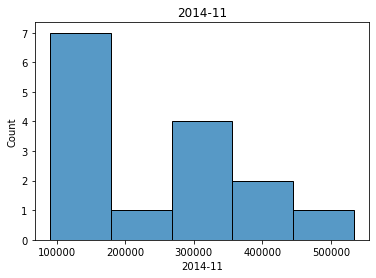

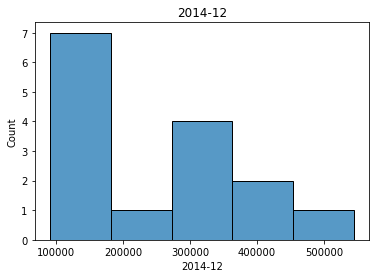

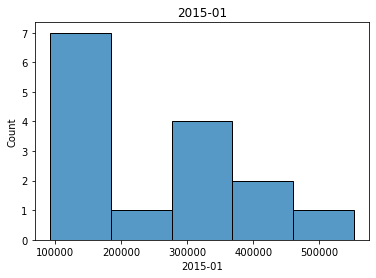

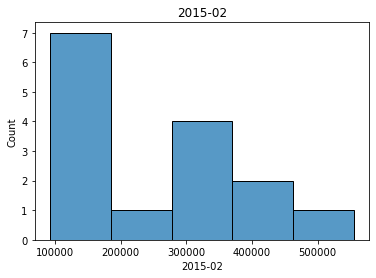

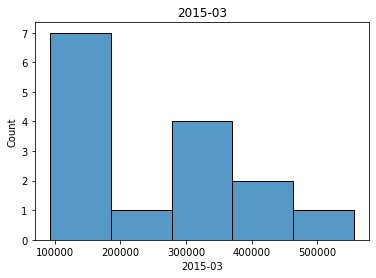

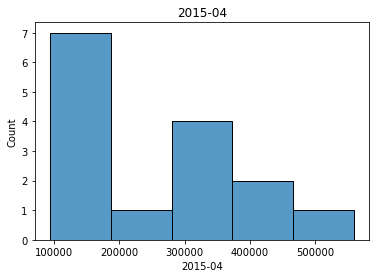

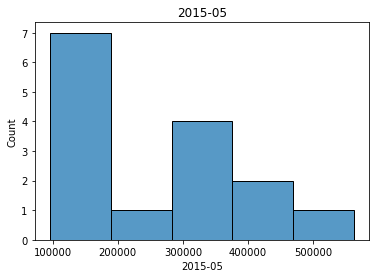

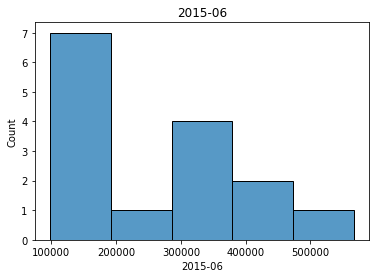

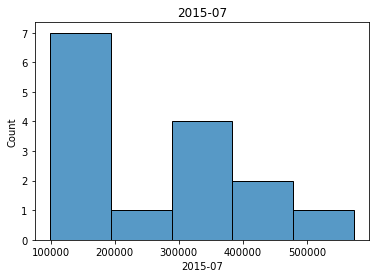

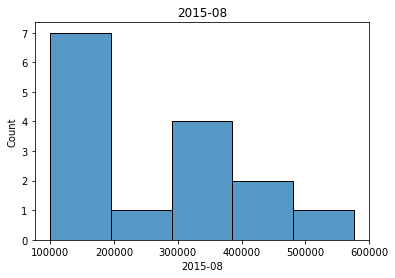

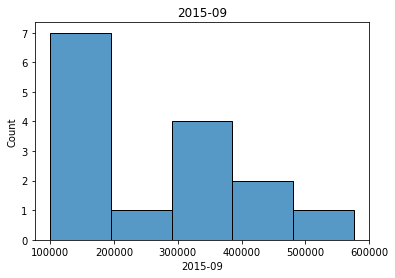

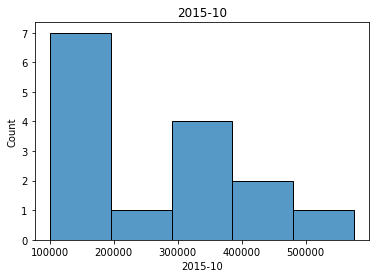

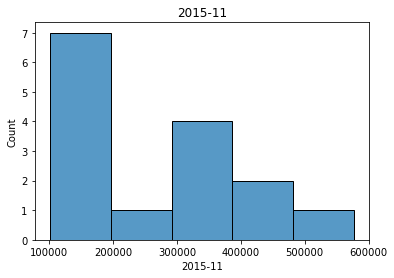

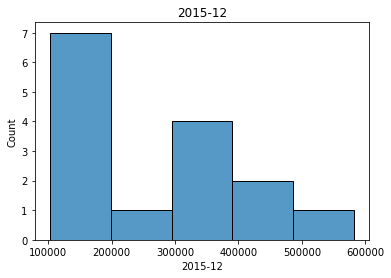

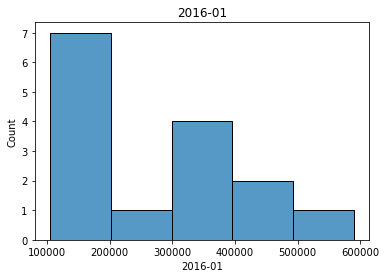

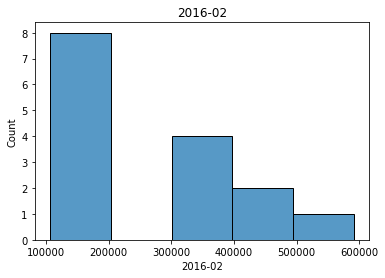

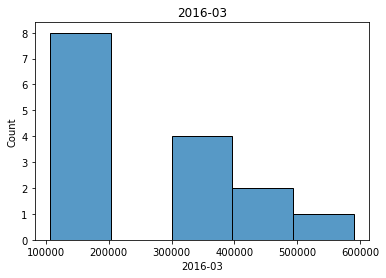

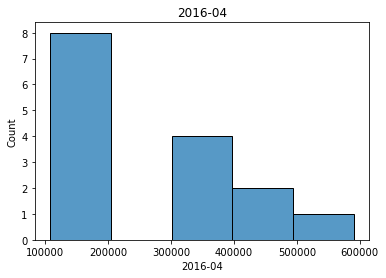

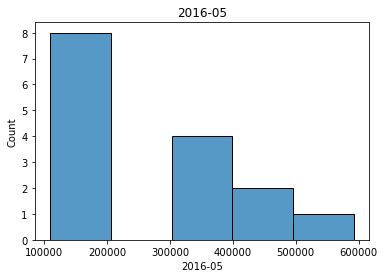

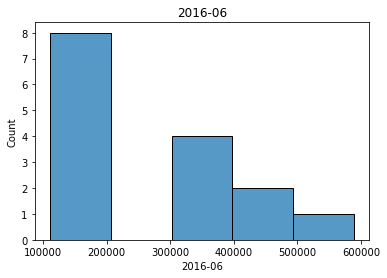

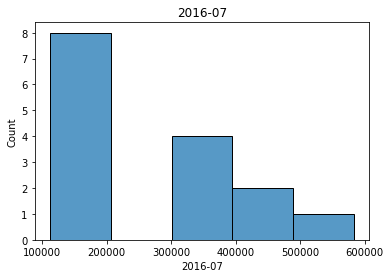

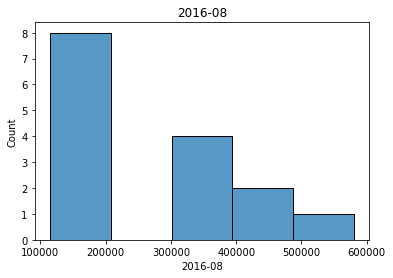

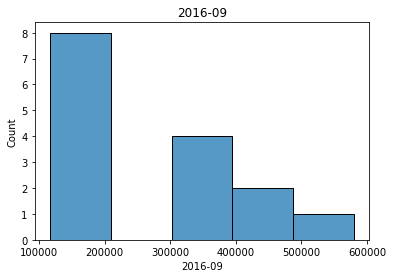

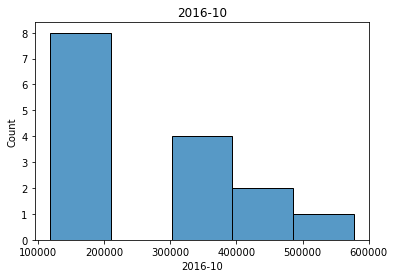

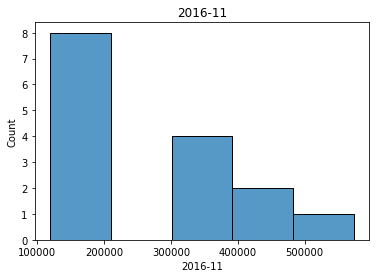

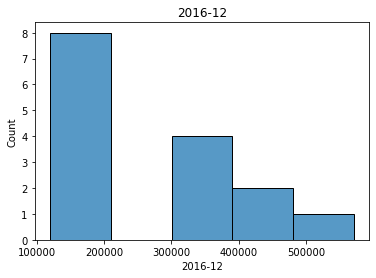

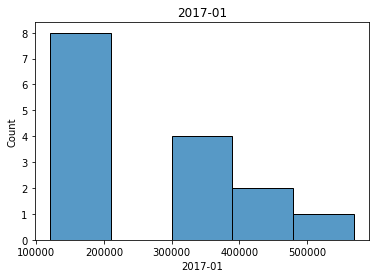

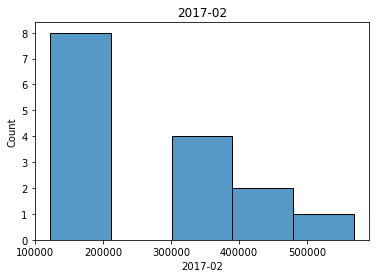

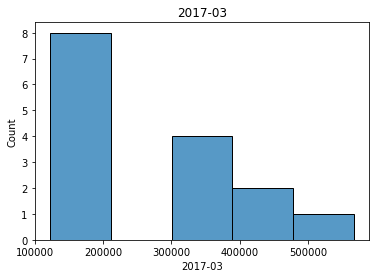

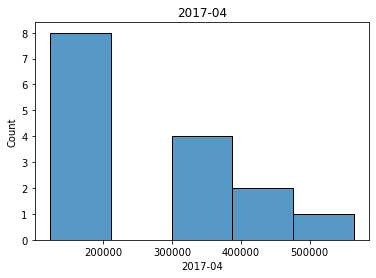

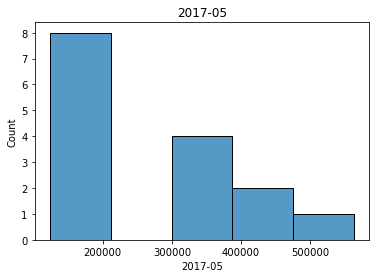

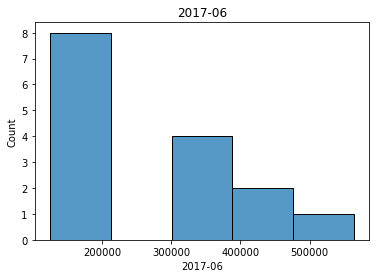

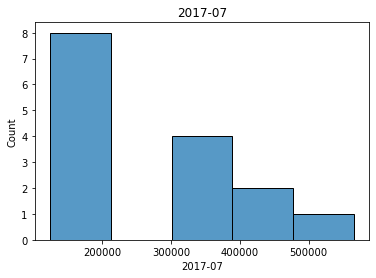

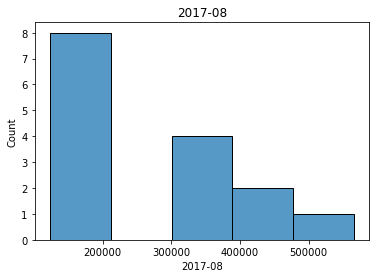

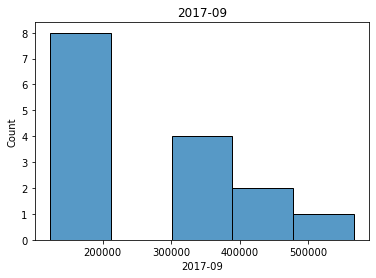

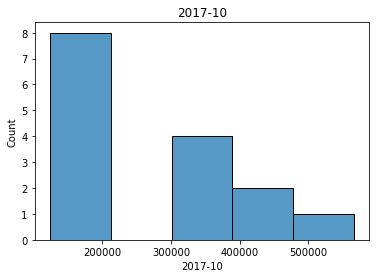

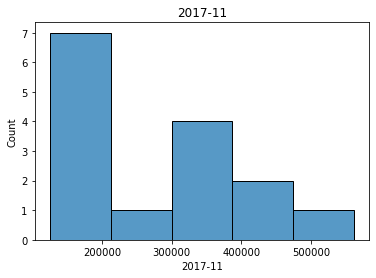

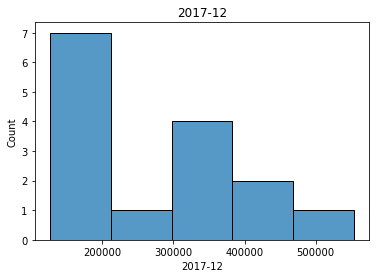

In [31]:
# each months distributions
for i in range(len(zipcode.index)):
    sns.histplot(zipcode.loc[zipcode.index[i]])
    plt.title(zipcode.index[i])
    plt.show()

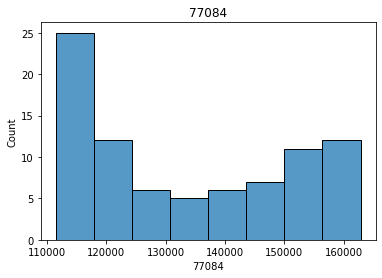

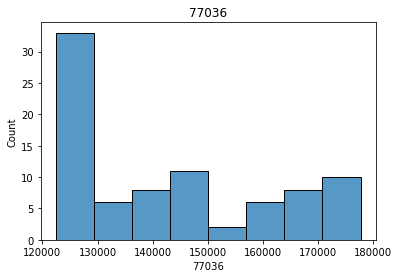

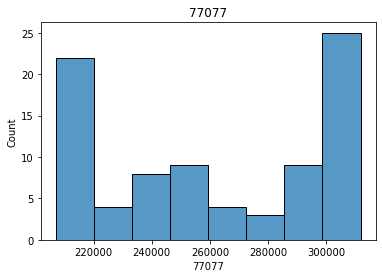

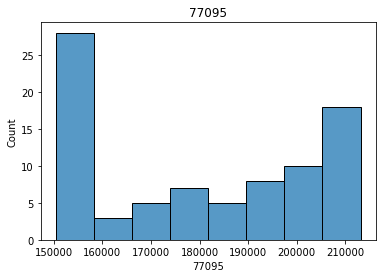

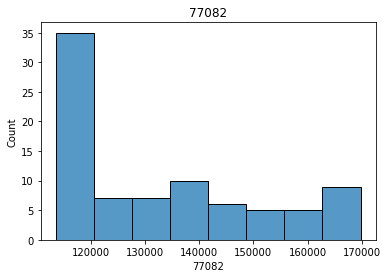

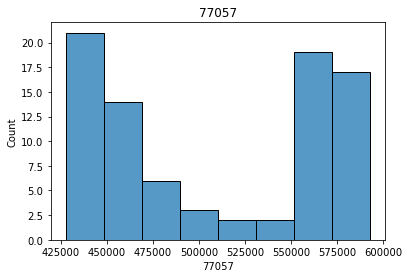

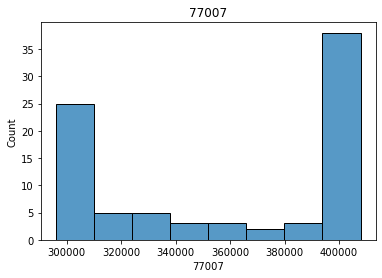

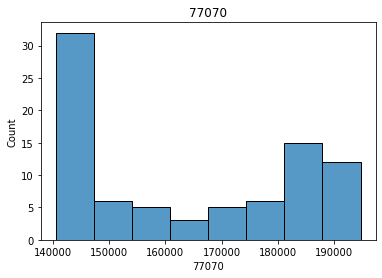

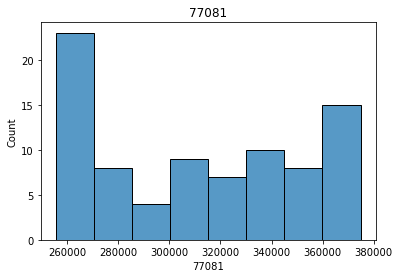

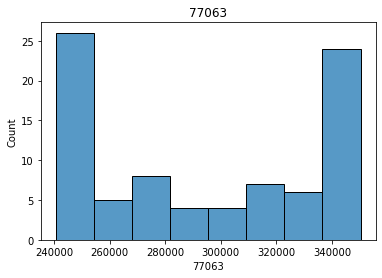

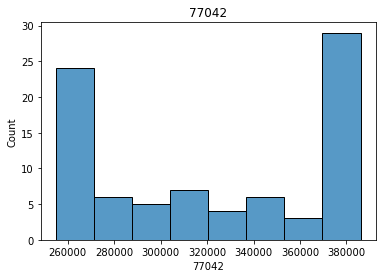

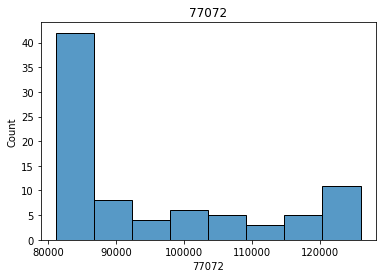

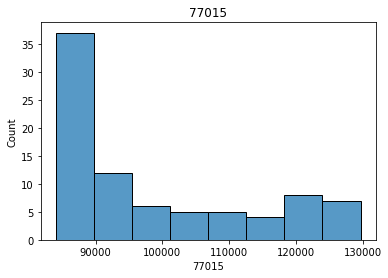

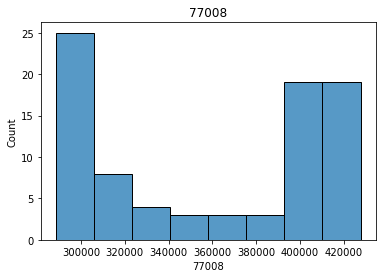

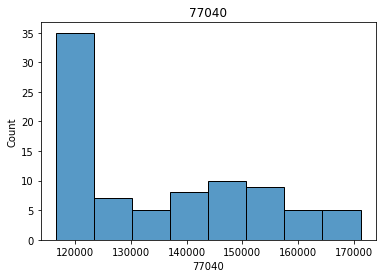

In [32]:
# Distribution for each zipcode from 2011-1017
for c in zipcode.columns:
    sns.histplot(zipcode[c])
    plt.title(c)
    plt.show()

#### SARIMA

Determine 'pdq' for SARIMA model. Since each future value predicted is dependent on where previous value was. Each effect is weighted, how much the error is, and each error combined with the last. 
- number of Auto-Regressive terms (p): uses the effect of past values into the model
- number of Differences (d): amount of differencing as it identifies the numer of lag values to subtract from the current observation. 
- number of Moving Average terms (q): set the error of the model as a linear combination of the error values observed previous time points in the past. 

In [33]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [34]:
def pdq_func(df):
    ans = []

    for comb in pdq:
            for combs in pdqs:
                try:
                    mod = SARIMAX(df,
                                  order=comb,
                                  seasonal_order=combs,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

                    output = mod.fit()
                    ans.append([comb, combs, output.aic])
                except:
                    continue
                    
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    
    return ans_df.loc[ans_df['aic'].idxmin()]

In [35]:
pdq_li= []
pdqs_li = []
for c in zipcode.columns:
    a = pdq_func(zipcode[c])
    pdq_li.append(a[0])
    pdqs_li.append(a[1])
    print(a)
    print('')

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic        845.013003
Name: 59, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic        906.440006
Name: 63, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic        924.881463
Name: 63, dtype: object

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic        845.104604
Name: 59, dtype: object

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic        848.330653
Name: 59, dtype: object

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic       1051.945377
Name: 59, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic        941.889327
Name: 63, dtype: object

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic        819.822075
Name: 59, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic       1038.059726
Name: 63, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic       1003.608801
Name: 63, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic        987.367659
Name: 63, dtype: object


The best pdq options. 

In [36]:
def sarimax_model(df, pdq, pdqs, start=None, end=None ):
    model = SARIMAX(df,
                    order=pdq, 
                    seasonal_order=pdqs, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    #fit model
    output = model.fit()
    #predictions
    pred = output.get_prediction(start=pd.to_datetime(start), end=pd.to_datetime(end),dynamic=False)
    return pred

In [37]:
zip_col = list(zipcode.columns)
zip_col

['77084',
 '77036',
 '77077',
 '77095',
 '77082',
 '77057',
 '77007',
 '77070',
 '77081',
 '77063',
 '77042',
 '77072',
 '77015',
 '77008',
 '77040']

In [38]:
# chosen zipcode dataframe up to 2016
zipcode_2016 = zipcode[:'2016-12']
zipcode_2016

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
2011-01,118800.0,125000.0,207100.0,155600.0,118900.0,439200.0,297300.0,144400.0,259500.0,244100.0,256900.0,83700.0,86700.0,289000.0,120500.0
2011-02,118300.0,125400.0,207100.0,154600.0,118200.0,436900.0,296600.0,143800.0,257300.0,243800.0,255400.0,83400.0,86400.0,288700.0,119700.0
2011-03,118200.0,125900.0,207600.0,154500.0,117900.0,435100.0,296600.0,143200.0,256000.0,244100.0,255000.0,82800.0,86300.0,289000.0,119500.0
2011-04,118100.0,126200.0,209100.0,154800.0,117500.0,435200.0,297200.0,142900.0,258400.0,244400.0,255700.0,82200.0,86300.0,290100.0,119700.0
2011-05,118000.0,126400.0,210700.0,155100.0,117000.0,436600.0,298200.0,142800.0,261900.0,245600.0,256500.0,82100.0,86200.0,292000.0,119600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08,155500.0,167000.0,311000.0,205700.0,151300.0,580800.0,401100.0,186300.0,350100.0,345500.0,375100.0,114300.0,116200.0,407800.0,154300.0
2016-09,155400.0,168100.0,311000.0,206200.0,153100.0,580300.0,400100.0,186500.0,356200.0,341600.0,375200.0,116300.0,117200.0,408500.0,155500.0
2016-10,155000.0,168200.0,310600.0,206800.0,155600.0,577900.0,398300.0,186900.0,361100.0,337600.0,375700.0,117700.0,118300.0,409400.0,156200.0
2016-11,155100.0,167900.0,309600.0,207500.0,157700.0,574300.0,397400.0,187400.0,362600.0,336400.0,377700.0,118600.0,119100.0,410300.0,156100.0


In [39]:
#using 2016 dataframe to predict 2017 values
zipcode_pred_mean = pd.DataFrame()
for c in range(0,15):
    pred = sarimax_model(zipcode_2016.iloc[:,c], pdq_li[c], pdqs_li[c], start='2017-01', end='2017-12')
    pred_mean_dict = {c: list(pred.predicted_mean)}
    pred_mean_df = pd.DataFrame(pred_mean_dict)
    zipcode_pred_mean = pd.concat([zipcode_pred_mean, pred_mean_df], axis=1)

In [40]:
zipcode_pred_mean.columns = zipcode.columns
zipcode_pred_mean

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
0,157021.850011,168397.428424,307754.505533,208434.605448,159472.868389,570506.640360,396690.704963,188699.715135,362315.074631,339702.983075,383498.513001,120110.208772,120207.854635,412157.053871,156379.712562
1,157998.709518,167762.241747,306872.210431,208597.812334,160226.551454,565807.790747,396364.314982,189209.527709,360953.445946,340172.254875,387246.549043,120550.199926,120794.944374,413512.111648,156851.868650
2,158759.060568,165792.617968,305931.076828,208329.718524,160902.860292,559025.395646,395349.018493,189688.747251,361567.261591,339934.717574,391205.056027,120934.950838,121406.437943,413471.600903,157302.776405
3,159552.568753,164449.856310,305211.254286,208400.383845,161684.387574,555370.976875,394338.639428,190296.195675,363987.230457,340096.566719,394613.014199,121528.128823,122158.650487,413480.208899,158121.040760
4,160669.885011,165621.933811,304733.613919,208906.380636,162735.290441,553920.314095,393023.641839,191139.582108,367326.286594,340733.274887,397990.582531,122579.313756,123130.698832,413899.862611,159312.698376
5,161842.872670,168194.186856,303962.126969,209236.312838,163801.135483,547389.705940,391100.495263,192054.854992,371050.882660,342221.619825,401546.817627,123602.507784,124075.257202,412423.843785,160466.092439
6,162736.757893,170445.527727,302473.565611,209432.031004,164738.118736,538857.618399,390120.760666,192887.371659,375663.733319,346842.371598,405474.199278,124691.908118,124788.928950,409940.247216,161422.489716
7,163396.563306,171977.624910,300788.474694,209601.984319,165735.336660,534264.241461,389857.026441,193512.177400,378772.967128,352051.374081,409348.017157,125807.584863,125530.006844,408982.193584,162374.762458
8,163794.341453,172923.483038,299639.902301,210001.129481,166910.523550,532617.623553,388664.902397,194123.470014,380270.749594,355203.893458,411817.103599,126784.672423,126203.285151,409415.111522,163375.129506
9,163986.335710,172985.057536,298710.183278,210500.968984,168452.513833,529229.570403,386729.614032,194809.793393,380140.236453,355899.908882,412347.674069,127516.081002,126863.509560,410012.749843,164034.684701


Predicitons for 2017 using SARIMAX model on zip code data from 2011-2016.

In [41]:
#root mean squared error for predicted mean and actual. from 2017-01 : 2017-12
for c in zipcode.columns:
    mse_2017 = round(sqrt(mean_squared_error(zipcode['2017-01':'2017-12'][c], zipcode_pred_mean[c])), 2)

    print(c)
    print('MSE: {}'.format(mse_2017))
    print('-----------------------------------------------------------------------------')
    print('')

77084
MSE: 2963.07
-----------------------------------------------------------------------------

77036
MSE: 5235.82
-----------------------------------------------------------------------------

77077
MSE: 8718.57
-----------------------------------------------------------------------------

77095
MSE: 817.04
-----------------------------------------------------------------------------

77082
MSE: 1052.57
-----------------------------------------------------------------------------

77057
MSE: 24979.36
-----------------------------------------------------------------------------

77007
MSE: 13020.06
-----------------------------------------------------------------------------

77070
MSE: 735.8
-----------------------------------------------------------------------------

77081
MSE: 5988.28
-----------------------------------------------------------------------------

77063
MSE: 11350.76
-----------------------------------------------------------------------------

77042
MSE: 22095.09


Mean squared error for, predicted 2017 zip codes compared to the original 2017 data. 

In [42]:
#mean squared error dataframe for 2017 predicted to actual dataframe.  
mse_2017_df = pd.DataFrame()
for c in zipcode.columns:
    mse_2017 = round(sqrt(mean_squared_error(zipcode.loc['2017-01':'2017-12', c], zipcode_pred_mean[c])), 2)
    mse_dict_2017 = {c: mse_2017}
    mse_series_2017 = pd.Series(mse_dict_2017)
    mse_series_2017.index = [0]
    mse_2017_df = pd.concat([mse_2017_df, mse_series_2017], axis=1)


In [43]:
mse_2017_df.columns = zipcode.columns
mse_2017_sort = mse_2017_df.sort_values(by=[0], axis=1)
mse_2017_sort

,77015,77070,77095,77082,77072,77040,77084,77036,77081,77077,77008,77063,77007,77042,77057
0,672.52,735.8,817.04,1052.57,2438.76,2757.58,2963.07,5235.82,5988.28,8718.57,10044.31,11350.76,13020.06,22095.09,24979.36


Make 2017 mean squared error results into dataframe.

In [44]:
mse_2017_sort.iloc[:, :5]

,77015,77070,77095,77082,77072
0,672.52,735.8,817.04,1052.57,2438.76


Top 5 zipcode models for predicting the year 2017:
 - 77015
 - 77070
 - 77095
 - 77082
 - 77072

#### 2018-01:2020-12 Prediction

In [45]:
#future mean predition 2018-2020
future_mean = pd.DataFrame()
conf_int = pd.DataFrame()
#list of prediciotn models
pred_res = []
for c in range(0,15):
    pred = sarimax_model(zipcode_2016.iloc[:,c], pdq_li[c], pdqs_li[c], start='2018-01', end='2020-12')
    pred_mean_dict = {c: list(pred.predicted_mean)}
    pred_mean_df = pd.DataFrame(pred_mean_dict)
    future_mean = pd.concat([future_mean, pred_mean_df], axis=1)
    
    conf_int = pd.concat([conf_int, pred.conf_int()], axis=1)
    
    pred_res.append(pred)

In [46]:
future_mean.columns = zipcode.columns
future_mean

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
0,166471.305328,173421.711968,296666.809904,212143.227277,171851.219586,518694.744256,384630.231184,197059.940129,378952.547278,353040.351962,415571.698784,130187.559843,128743.742953,412194.673813,165077.425397
1,167451.564716,172842.051310,296371.401904,212420.537586,172710.497839,513194.959372,384218.405521,197706.851738,377561.424213,355708.044676,418207.538022,130824.944925,129420.407450,413453.364075,165679.335667
2,168214.649330,170914.315401,295858.139098,212250.116955,173447.857840,505786.132379,383132.744125,198306.736269,377311.617278,358148.783033,421358.677609,131356.558665,130086.795695,413337.823351,166200.894464
3,169010.355346,169601.901077,295686.686340,212404.391073,174264.682605,501641.765256,382066.031298,199020.385583,378811.571121,360920.790522,423843.660434,132059.003892,130854.073615,413284.482997,167057.628251
4,170129.438700,170793.495213,295623.991877,212981.957470,175335.993147,499807.901381,380707.649496,199957.242618,381820.123828,363310.422491,425369.342385,133191.484619,131817.109316,413647.928972,168270.232440
5,171303.847134,173377.784466,295189.172900,213373.153661,176413.637138,492977.581882,378745.047983,200954.781794,384985.223835,364006.976764,426603.767343,134275.163436,132735.823814,412130.262601,169435.031894
6,172198.874685,175637.935304,294056.029096,213621.314151,177357.442099,484211.082458,377723.120535,201859.703500,388484.434394,362882.430079,428264.987677,135409.564988,133445.778149,409618.495594,170397.639396
7,172859.598549,177177.558775,292822.502351,213836.158393,178358.604077,479434.366011,377421.131423,202548.235098,391454.664922,360572.194267,430117.898180,136558.723036,134184.742928,408627.482158,171353.293601
8,173258.115146,178129.668467,291872.075347,214273.730444,179536.071272,477644.353600,376200.721294,203215.614757,395091.965703,357342.616354,431303.626001,137560.720982,134848.992703,409020.571089,172355.501852
9,173450.703131,178197.257552,290890.116942,214806.463583,181079.379940,474144.147954,374242.013425,203951.302034,397298.849700,353779.738133,431885.481814,138310.663109,135491.997673,409579.591536,173016.059581


In [47]:
#setting idex to date time.
future_dti = pd.to_datetime(pd.date_range('2018-01', '2021-01', freq='M'))
future_dti = future_dti.strftime('%Y-%m')

In [48]:
#future mean predictions for each month 2018-2020
future_mean.set_index(future_dti, inplace=True)
future_mean

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
2018-01,166471.305328,173421.711968,296666.809904,212143.227277,171851.219586,518694.744256,384630.231184,197059.940129,378952.547278,353040.351962,415571.698784,130187.559843,128743.742953,412194.673813,165077.425397
2018-02,167451.564716,172842.051310,296371.401904,212420.537586,172710.497839,513194.959372,384218.405521,197706.851738,377561.424213,355708.044676,418207.538022,130824.944925,129420.407450,413453.364075,165679.335667
2018-03,168214.649330,170914.315401,295858.139098,212250.116955,173447.857840,505786.132379,383132.744125,198306.736269,377311.617278,358148.783033,421358.677609,131356.558665,130086.795695,413337.823351,166200.894464
2018-04,169010.355346,169601.901077,295686.686340,212404.391073,174264.682605,501641.765256,382066.031298,199020.385583,378811.571121,360920.790522,423843.660434,132059.003892,130854.073615,413284.482997,167057.628251
2018-05,170129.438700,170793.495213,295623.991877,212981.957470,175335.993147,499807.901381,380707.649496,199957.242618,381820.123828,363310.422491,425369.342385,133191.484619,131817.109316,413647.928972,168270.232440
2018-06,171303.847134,173377.784466,295189.172900,213373.153661,176413.637138,492977.581882,378745.047983,200954.781794,384985.223835,364006.976764,426603.767343,134275.163436,132735.823814,412130.262601,169435.031894
2018-07,172198.874685,175637.935304,294056.029096,213621.314151,177357.442099,484211.082458,377723.120535,201859.703500,388484.434394,362882.430079,428264.987677,135409.564988,133445.778149,409618.495594,170397.639396
2018-08,172859.598549,177177.558775,292822.502351,213836.158393,178358.604077,479434.366011,377421.131423,202548.235098,391454.664922,360572.194267,430117.898180,136558.723036,134184.742928,408627.482158,171353.293601
2018-09,173258.115146,178129.668467,291872.075347,214273.730444,179536.071272,477644.353600,376200.721294,203215.614757,395091.965703,357342.616354,431303.626001,137560.720982,134848.992703,409020.571089,172355.501852
2018-10,173450.703131,178197.257552,290890.116942,214806.463583,181079.379940,474144.147954,374242.013425,203951.302034,397298.849700,353779.738133,431885.481814,138310.663109,135491.997673,409579.591536,173016.059581


Make zip codes predicted value from 2018-01 : 2020-12, into dataframe. 

#### Plot Zip code Predicitons

In [49]:
def future_plot(z , i):
    fig, ax = plt.subplots()
    
    #plot initial average
    ax.plot(zipcode.index, zipcode.loc[:, z], color='g')

    #conf interval
    ax.fill_between(future_mean.index, 
                     pred_res[i].conf_int().iloc[:, 1],
                     pred_res[i].conf_int().iloc[:, 0],
                   )
    #plot prediction 2018-2020
    ax.plot(future_mean.index, future_mean[z], color='r')
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Future Predicitons for Zip Code {}'.format(z))
    
    plt.xticks(ticks=range(0,132,12), labels=['2011', '2012','2013','2014','2015','2016','2017','2018','2019','2020', '2021'])

    
    plt.show()
    
    return None

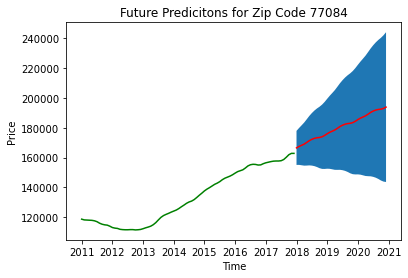

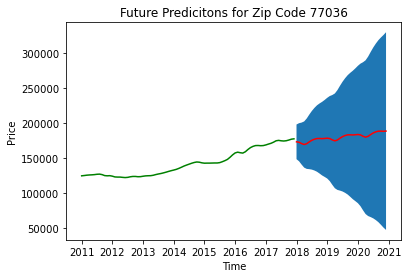

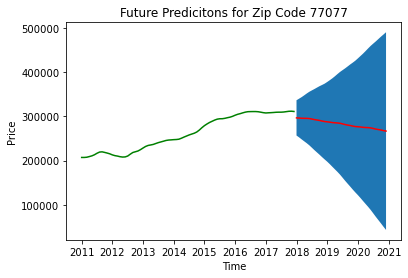

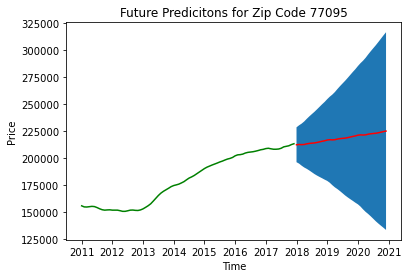

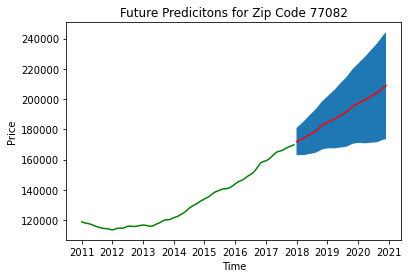

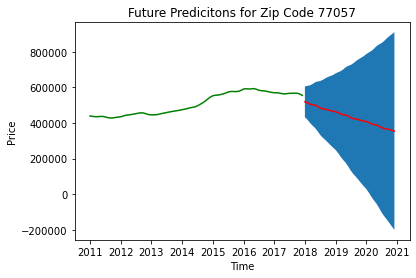

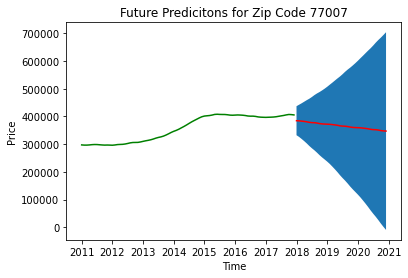

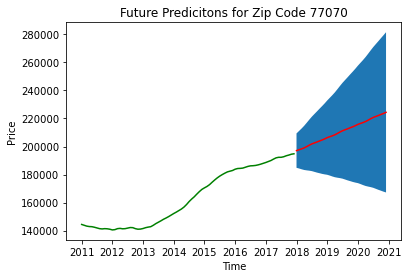

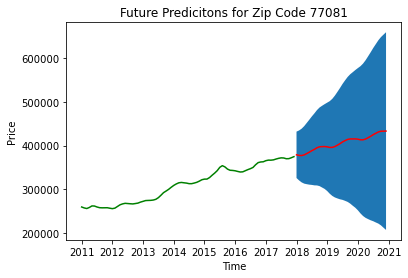

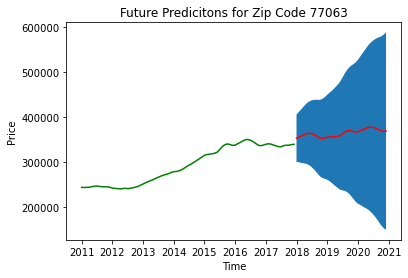

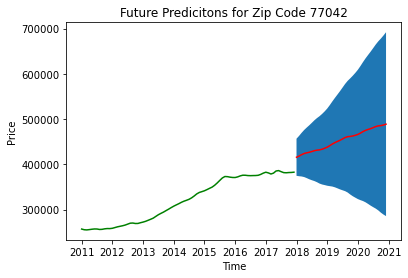

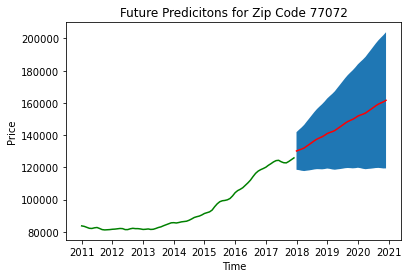

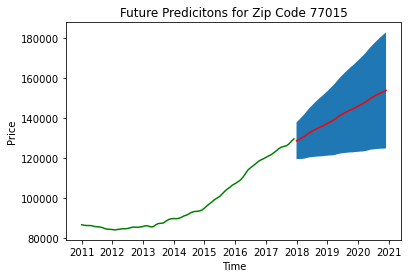

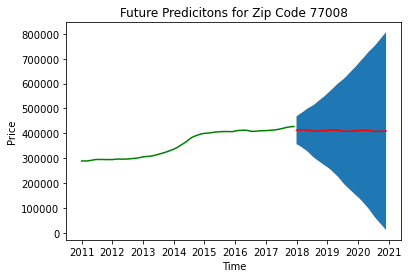

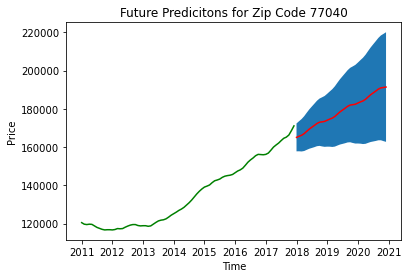

In [50]:
for r in range(0,15):
    future_plot(zip_col[r],r)

Ploting all zip codes current mean with future prediciton mean and confidence intervals. 

#### Mean Squared Error over Time

Comparing the average mean predicted to the confidence interval, over time. 

In [51]:
mse_future_conf_df = pd.DataFrame()
for r in range(0,15):
    conf_int_indexed = pred_res[r].conf_int().set_index(future_dti)
    
    mse = round(sqrt(mean_squared_error(future_mean[zip_col[r]], conf_int_indexed.iloc[:, 0])), 2)
    mse_dict = {zip_col[r]: mse}
    mse_series = pd.Series(mse_dict)
    mse_series.index = [0]
    mse_future_conf_df = pd.concat([mse_future_conf_df, mse_series], axis=1)

In [52]:
mse_future_conf_df.columns = zipcode.columns
mse_future_conf_df

,77084,77036,77077,77095,77082,77057,77007,77070,77081,77063,77042,77072,77015,77008,77040
0,32071.25,85860.69,135275.31,55834.99,23074.01,331411.25,210815.63,36454.65,143195.94,138043.88,124985.69,28207.95,20119.16,233293.93,18681.08


In [53]:
mse_future_conf_df_sort = mse_future_conf_df.sort_values(by=[0] , axis=1)
mse_future_conf_df_sort.iloc[:, :5]

,77040,77015,77082,77072,77084
0,18681.08,20119.16,23074.01,28207.95,32071.25


The top 5 zip code models with the lowest mean squared error for their predicitons:
 - 77040
 - 77015
 - 77082
 - 77072
 - 77084

#### Plotting the top Models

In [54]:
top_5_zip = zipcode.loc[:, ['77040', '77015', '77082', '77072', '77084']]

In [55]:
top_5_future = future_mean.loc[:, ['77040', '77015', '77082', '77072', '77084']]

In [56]:
top_5_models = pd.concat([top_5_zip, top_5_future], axis=0)
top_5_models

,77040,77015,77082,77072,77084
2011-01,120500.000000,86700.000000,118900.000000,83700.000000,118800.000000
2011-02,119700.000000,86400.000000,118200.000000,83400.000000,118300.000000
2011-03,119500.000000,86300.000000,117900.000000,82800.000000,118200.000000
2011-04,119700.000000,86300.000000,117500.000000,82200.000000,118100.000000
2011-05,119600.000000,86200.000000,117000.000000,82100.000000,118000.000000
...,...,...,...,...,...
2020-08,189318.437443,151474.679287,203615.942648,158252.738371,191792.909873
2020-09,190320.646946,152138.543606,204793.413028,159255.473603,192191.484293
2020-10,190981.205355,152780.689013,206336.723538,160005.964277,192384.118767
2020-11,191165.712385,153335.958807,207784.290323,160702.116855,192856.884574


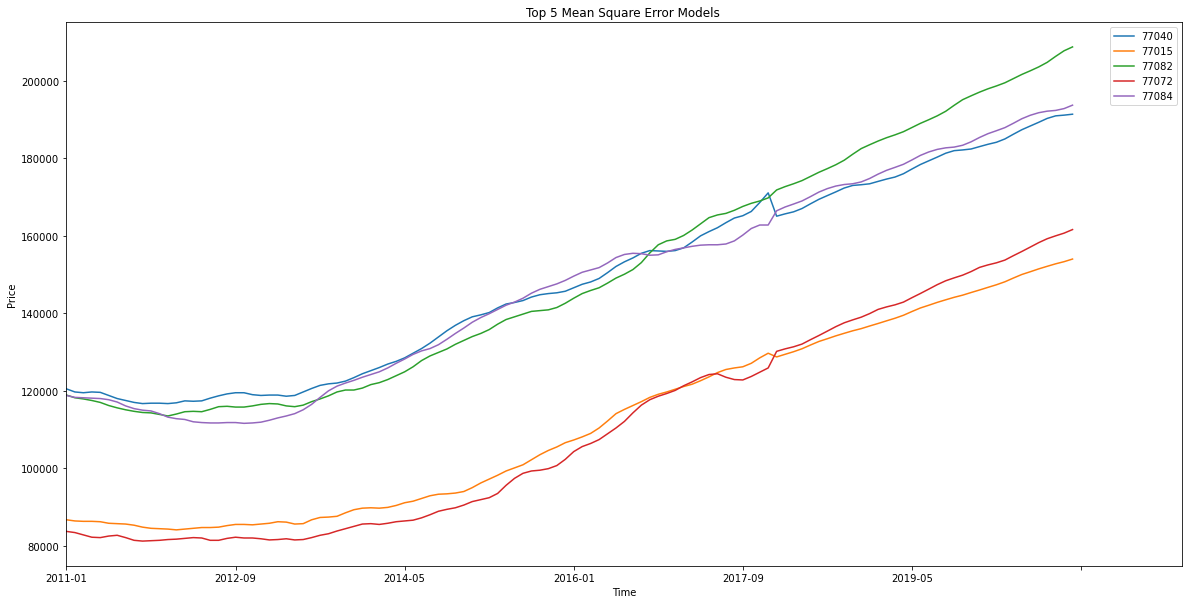

In [57]:
top_5_models.plot(figsize=(20,10), 
                  use_index=True, 
                  xlim=(0,132), 
                  title= 'Top 5 Mean Square Error Models ',
                  xlabel='Time', 
                  ylabel='Price');

In [58]:
for c in top_5_models.columns:
    print('')
    print('Zip Code: {}' .format(c))
    print('')
    print('Date: {}' .format(top_5_models[c].idxmin()))
    print('Minimum Value: ${}'.format(round(top_5_models[c].min(),2)))
    print('')
    print('Date: {}' .format(top_5_models[c].idxmax()))
    print('Maximum Value: ${}' .format(round(top_5_models[c].max(),2)))
    print('---------------------------------------------------------------------------')



Zip Code: 77040

Date: 2011-10
Minimum Value: $116700.0

Date: 2020-12
Maximum Value: $191406.78
---------------------------------------------------------------------------

Zip Code: 77015

Date: 2012-02
Minimum Value: $84100.0

Date: 2020-12
Maximum Value: $154015.97
---------------------------------------------------------------------------

Zip Code: 77082

Date: 2012-01
Minimum Value: $113500.0

Date: 2020-12
Maximum Value: $208781.13
---------------------------------------------------------------------------

Zip Code: 77072

Date: 2011-10
Minimum Value: $81200.0

Date: 2020-12
Maximum Value: $161626.68
---------------------------------------------------------------------------

Zip Code: 77084

Date: 2012-10
Minimum Value: $111600.0

Date: 2020-12
Maximum Value: $193743.94
---------------------------------------------------------------------------


In [59]:
model_diff_li = []
for c in top_5_models.columns:
    model_diff = top_5_models[c].max() - top_5_models[c].min() 
    model_sum = top_5_models[c].max() + top_5_models[c].min()
    model_growth_pred = (model_diff / (model_sum/2)) * 100
    model_diff_li.append(model_growth_pred)

In [60]:
model_diff_li

[48.49408234732305,
 58.724303111287654,
 59.12920021703735,
 66.24204732500239,
 53.80420440468101]

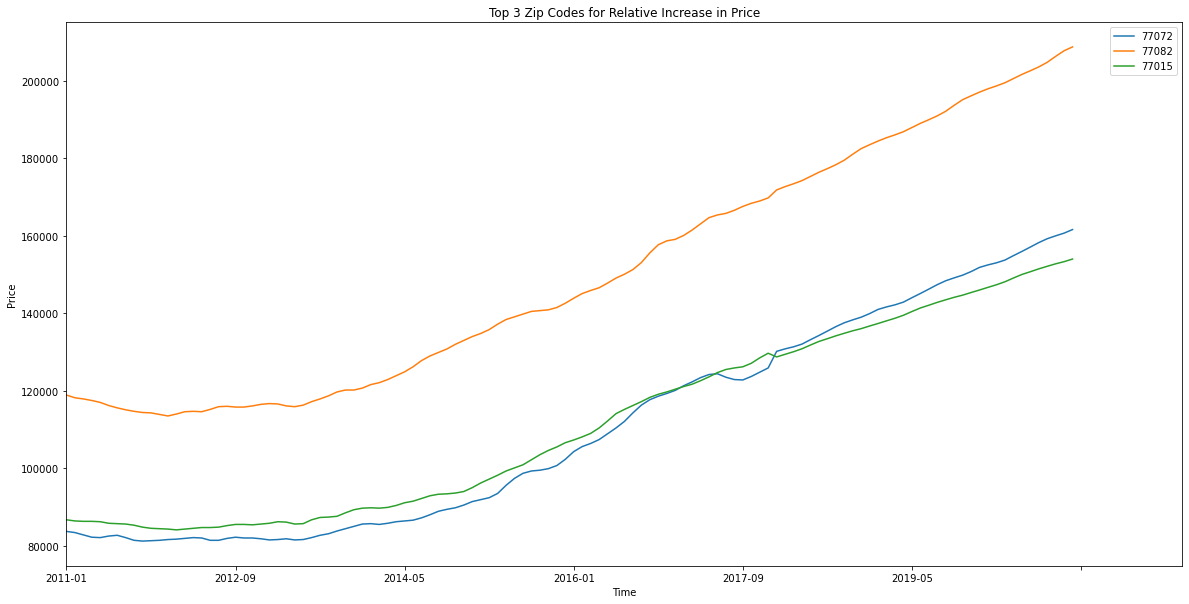

In [61]:
top_5_models.loc[:, ['77072', '77082', '77015']].plot(figsize=(20,10), 
                                                      use_index=True, 
                                                      xlim=(0,132),
                                                      title= 'Top 3 Zip Codes for Relative Increase in Price',
                                                      xlabel='Time', 
                                                      ylabel='Price');

Zip codes , have a differnce minimum price and maximum price, over the average of the minimum and maximum. 